In [ ]:
import pandas as pd
import numpy as np


# NEED TO ADD TILT TO GALAXIES


rmin = 25.0                         # kpcs
G = 1                               # (kpc)^3 / ((M_sol)(yr * 10^8)^2)
M = 10**11 * (4.498 * 10**(-6))     # 10^11 solar masses in G=1 units)
m = M * 10**(-12)
ecc = 0.5
wa = np.radians(-30)
ia = np.radians(60)
wb = np.radians(30)
ib = np.radians(-60)


# tilt rotation matrices
rotxa = np.array([[1, 0, 0],
                 [0, np.cos(wa), -1*np.sin(wa)],
                 [0, np.sin(wa), np.cos(wa)]])

rotya = np.array([[np.cos(ia), 0, np.sin(ia)],
                 [0, 1, 0],
                 [-1*np.sin(ia), 0, np.cos(ia)]])

rotza = np.array([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]])   
temprot = np.matmul(rotza, rotya)
rotmatrixa = np.matmul(temprot, rotxa)


rotxb = np.array([[1, 0, 0],
                 [0, np.cos(wb), -1*np.sin(wb)],
                 [0, np.sin(wb), np.cos(wb)]])

rotyb = np.array([[np.cos(ib), 0, np.sin(ib)],
                 [0, 1, 0],
                 [-1*np.sin(ib), 0, np.cos(ib)]])

rotzb = np.array([[1, 0, 0],
                 [0, 1, 0],
                 [0, 0, 1]])       
temprot = np.matmul(rotzb, rotyb)
rotmatrixb = np.matmul(temprot, rotxb)


# create galaxy of 345 disk particles, each particle has 6 parameters [x,y,z,vx,vy,vz,m]
# leftGalaxy[0] is the center of the galaxy point, everything else is a disk particle
leftGalaxyPos = np.zeros(shape=(342,3))
leftGalaxyVel = np.zeros(shape=(342,3))
rightGalaxyPos = np.zeros(shape=(342,3))
rightGalaxyVel = np.zeros(shape=(342,3))

leftGalaxy = np.zeros(6)
rightGalaxy = np.zeros(6)


def populateGalaxy(positions, velocities, orientation, rotmatrix):
    # rotation = 1: counterclockwise        rotation = -1, clockwise
    e = 0.2*rmin     # softening
    n = 12
    r = 0.2*rmin
    index = 0

    for k in range(12):
        v0 = np.sqrt(G*M*r / (r**2 + e**2))       # v0 for circular orbit

        # fill each ring with n particles
        for j in range(n):
            angle = j * 2*np.pi / n
            positions[index][0] = r * np.cos(angle)
            positions[index][1] = r * np.sin(angle)
            positions[index][2] = 0
            velocities[index][0] = orientation * v0 * np.cos(angle + np.pi/2)
            velocities[index][1] = orientation * v0 * np.sin(angle + np.pi/2)
            velocities[index][2] = 0

            # rotate all positions and velocities by rotation matrix
            positions[index] = rotmatrix @ positions[index]
            velocities[index] = rotmatrix @ velocities[index]

            index += 1

        n += 3
        r += 0.05*rmin


def shiftCenter(galaxy, positions, velocities, direction):
    # direction = 1: left galaxy        direction = -1: right galaxy
    a = rmin/2 / (1-ecc)
    # r = rmin * (1+e) / (1 - e * cos(0)) = a(1+e)
    r = a * (1+ecc)
    v = np.sqrt(G*M * (2/r - 1/a)) / 2
    galaxy[0] = -1 * direction * r
    galaxy[4] = direction * v

    positions[:,0] += galaxy[0]
    velocities[:,1] += galaxy[4]



populateGalaxy(leftGalaxyPos, leftGalaxyVel, -1, rotmatrixb)
populateGalaxy(rightGalaxyPos, rightGalaxyVel, -1, rotmatrixa)
shiftCenter(leftGalaxy, leftGalaxyPos, leftGalaxyVel, 1)
shiftCenter(rightGalaxy, rightGalaxyPos, rightGalaxyVel, -1)



aarsethParams = "{n} {eta} {dt} {T} {e}\n"         # {number of particles} {integration timestep} {major output timestep} {total time} {smoothing}
particle = "{mass} {x:0.6f} {y:0.6f} {z:0.6f} {vx:0.6f} {vy:0.6f} {vz:0.6f}\n"

f = open("initc.data", "w")

# setup aarseth code parameters
f.write(aarsethParams.format(n=686, eta=0.01, dt=0.01, T=10.0, e=(0.2*rmin)**2))

# write galaxy centers to file
f.write(particle.format(mass=M, x=leftGalaxy[0], y=leftGalaxy[1], z=leftGalaxy[2],
                            vx=leftGalaxy[3], vy=leftGalaxy[4], vz=leftGalaxy[5]))
f.write(particle.format(mass=M, x=rightGalaxy[0], y=rightGalaxy[1], z=rightGalaxy[2],
                            vx=rightGalaxy[3], vy=rightGalaxy[4], vz=rightGalaxy[5]))

# write galaxy particles to file
for j in range(342):
    f.write(particle.format(mass=m, x=leftGalaxyPos[j][0], y=leftGalaxyPos[j][1], z=leftGalaxyPos[j][2],
                                vx=leftGalaxyVel[j][0], vy=leftGalaxyVel[j][1], vz=leftGalaxyVel[j][2]))
    f.write(particle.format(mass=m, x=rightGalaxyPos[j][0], y=rightGalaxyPos[j][1], z=rightGalaxyPos[j][2],
                                vx=rightGalaxyVel[j][0], vy=rightGalaxyVel[j][1], vz=rightGalaxyVel[j][2]))

f.close()


In [154]:
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt

In [161]:
data = pd.read_csv("new.csv")
datb = pd.read_csv("new.csv")

In [162]:
# for i in range(data.len):
wa = np.radians(-30)
ia = np.radians(60)
wb = np.radians(30)
ib = np.radians(-60)
x = data.iloc[:,1]
y = data.iloc[:,2]
z = data.iloc[:,3]
vx = data.iloc[:,4]
vy = data.iloc[:,5]
vz = data.iloc[:,6]

data.iloc[:,1] = x*m.cos(ia) - z*m.sin(ia)
data.iloc[:,2] = x*m.sin(ia)*m.sin(wa) + y*m.cos(wa) + z*m.cos(ia)*m.sin(wa)
data.iloc[:,3] = x*m.sin(ia)*m.cos(wa) - y*m.sin(wa) + z*m.cos(ia)*m.cos(wa)
data.iloc[:,4] = vx*m.cos(ia) - vz*m.sin(ia)
data.iloc[:,5] = vx*m.sin(ia)*m.sin(wa) + vy*m.cos(wa) + vz*m.cos(ia)*m.sin(wa)
data.iloc[:,6] = vx*m.sin(ia)*m.cos(wa) - vy*m.sin(wa) + vz*m.cos(ia)*m.cos(wa)

rp = 0.5
ecc = 0.5
G = 1
M = 1.25*2.2*10**11 * (4.498 * 10**(-6))     # 10^11 solar masses in G=1 units)
a = rp/2 / (1-ecc)
r = a * (1+ecc)
v = np.sqrt(G*M * (2/r - 1/a)) / 2

for i in range(len(data.loc[data.iloc[:,0] >= 0.01])):
    data.iloc[i,1] += 1*r
    data.iloc[i,5] += -1*v

for i in range(len(data.loc[data.iloc[:,0] >= 0.01]),len(data)):
               data.iloc[i,1] += 1*r
               data.iloc[i,5] += -1*v
# data.loc[data.iloc[:,0] < 0.01].iloc[:,1] += data.loc[data.iloc[:,0] >= 0.01].iloc[:,1]
# data.loc[data.iloc[:,0] < 0.01].iloc[:,4] += data.loc[data.iloc[:,0] >= 0.01].iloc[:,4]
# data = data.loc[data.iloc[:,0] >= 0.001 ]
# data = data.loc[data.iloc[:,0] >= 0.01]
# data

In [163]:

wa = np.radians(30)
ia = np.radians(-60)
x = datb.iloc[:,1]
y = datb.iloc[:,2]
z = datb.iloc[:,3]
vx = datb.iloc[:,4]
vy = datb.iloc[:,5]
vz = datb.iloc[:,6]

datb.iloc[:,1] = x*m.cos(ia) - z*m.sin(ia)
datb.iloc[:,2] = x*m.sin(ia)*m.sin(wa) + y*m.cos(wa) + z*m.cos(ia)*m.sin(wa)
datb.iloc[:,3] = x*m.sin(ia)*m.cos(wa) - y*m.sin(wa) + z*m.cos(ia)*m.cos(wa)
datb.iloc[:,4] = vx*m.cos(ia) - vz*m.sin(ia)
datb.iloc[:,5] = vx*m.sin(ia)*m.sin(wa) + vy*m.cos(wa) + vz*m.cos(ia)*m.sin(wa)
datb.iloc[:,6] = vx*m.sin(ia)*m.cos(wa) - vy*m.sin(wa) + vz*m.cos(ia)*m.cos(wa)

rp = 0.5
ecc = 0.5
G = 1
M = 1.25*2.2*10**11 * (4.498 * 10**(-6))     # 10^11 solar masses in G=1 units)
a = rp/2 / (1-ecc)
r = a * (1+ecc)
v = np.sqrt(G*M * (2/r - 1/a)) / 2

for i in range(len(datb.loc[datb.iloc[:,0] >= 0.01])):
    datb.iloc[i,1] += -1*r
    datb.iloc[i,5] += 1*v

for i in range(len(datb.loc[datb.iloc[:,0] >= 0.01]),len(datb)):
               datb.iloc[i,1] += -1*r
               datb.iloc[i,5] += 1*v
# data.loc[data.iloc[:,0] < 0.01].iloc[:,1] += data.loc[data.iloc[:,0] >= 0.01].iloc[:,1]
# data.loc[data.iloc[:,0] < 0.01].iloc[:,4] += data.loc[data.iloc[:,0] >= 0.01].iloc[:,4]
# data = data.loc[data.iloc[:,0] >= 0.001 ]
# data = data.loc[data.iloc[:,0] >= 0.01]
# data

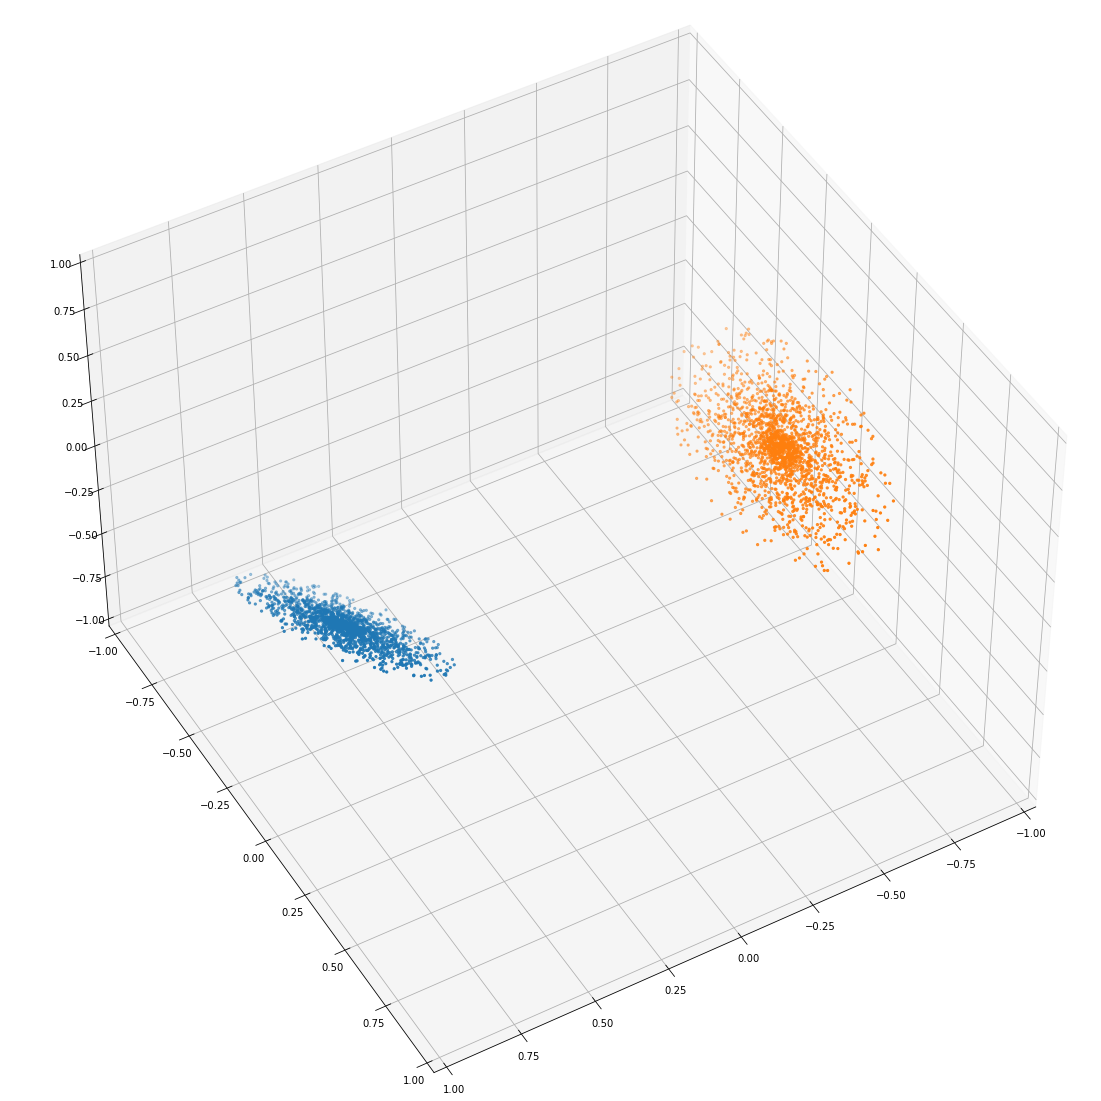

In [173]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter3D(data.iloc[0:1999,1], data.iloc[0:1999,2], data.iloc[0:1999,3], cmap='Greens',marker='.')
ax.scatter3D(datb.iloc[0:1999,1], datb.iloc[0:1999,2], datb.iloc[0:1999,3],marker='.')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.view_init(45,60)

In [174]:
particle = "{mass} {x:0.6f} {y:0.6f} {z:0.6f} {vx:0.6f} {vy:0.6f} {vz:0.6f}\n"

f = open("Halfinitc.dat", "w")

for i in range(20000):
    f.write(particle.format(mass=data.iloc[i,0], x=data.iloc[i,1], y=data.iloc[i,2], z=data.iloc[i,3],
                                vx=data.iloc[i,4], vy=data.iloc[i,5], vz=data.iloc[i,6]))
# for j in range(20000):
#     f.write(particle.format(mass=datb.iloc[j,0], x=datb.iloc[j,1], y=datb.iloc[j,2], z=datb.iloc[j,3],
#                                 vx=datb.iloc[j,4], vy=datb.iloc[j,5], vz=datb.iloc[j,6]))
for k in range(20000,146666):
    f.write(particle.format(mass=data.iloc[k,0], x=data.iloc[k,1], y=data.iloc[k,2], z=data.iloc[k,3],
                                vx=data.iloc[k,4], vy=data.iloc[k,5], vz=data.iloc[k,6]))
# for h in range(20000,146666):
#     f.write(particle.format(mass=datb.iloc[h,0], x=datb.iloc[h,1], y=datb.iloc[h,2], z=datb.iloc[h,3],
#                                 vx=datb.iloc[h,4], vy=datb.iloc[h,5], vz=datb.iloc[h,6]))
f.close()

In [169]:
len(datb.loc[datb.iloc[:,0] >= 0.01])

20000

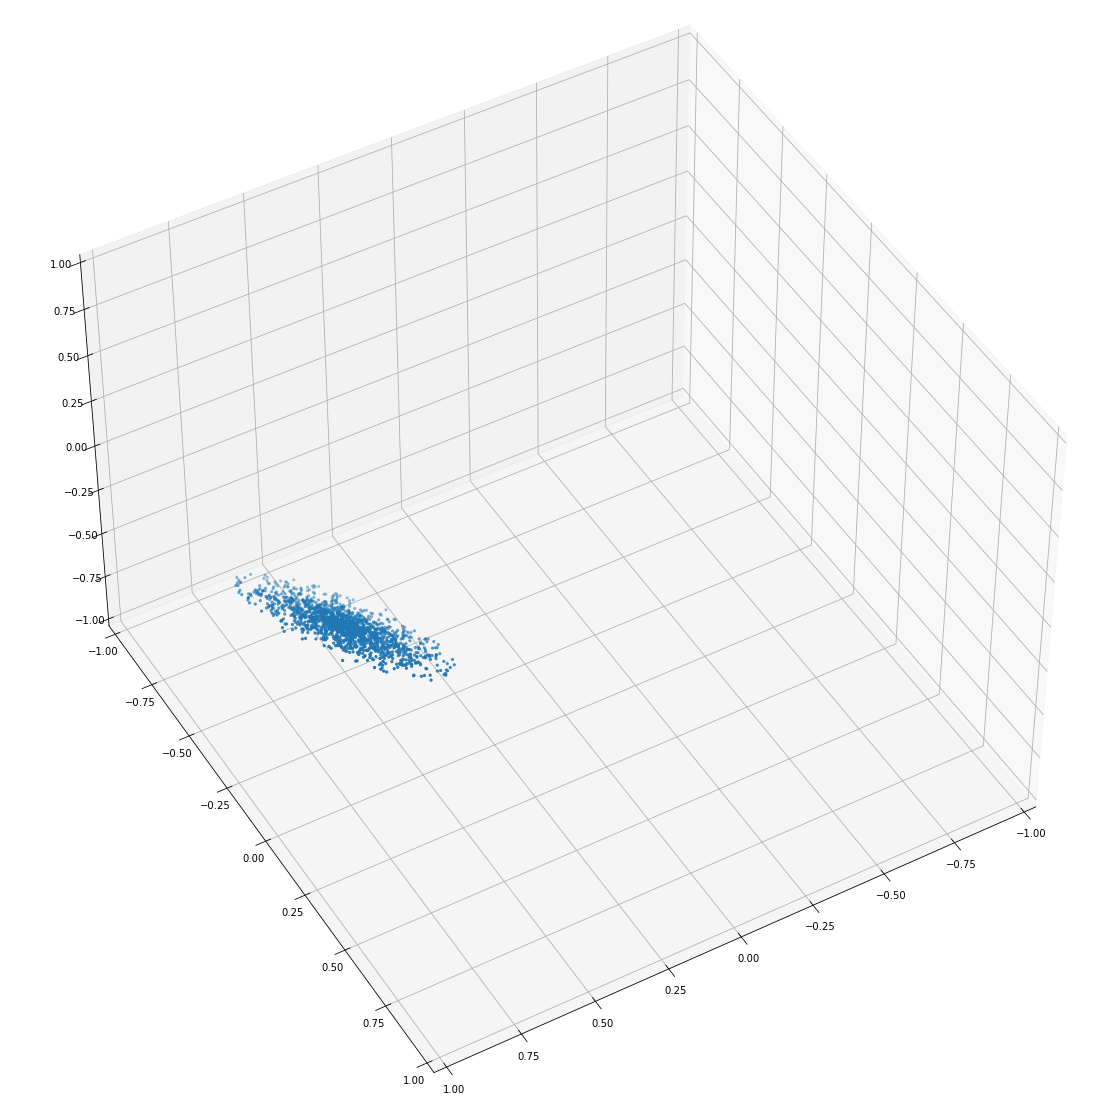

In [175]:
plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter3D(data.iloc[0:1999,1], data.iloc[0:1999,2], data.iloc[0:1999,3], cmap='Greens',marker='.')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax.view_init(45,60)